In [1]:
# Clone The ReNoise-Inversion HF code at a commit that we know works with our implementation
![[ -d ReNoise-Inversion ]] || git clone https://huggingface.co/spaces/garibida/ReNoise-Inversion
!pushd ReNoise-Inversion; git reset --hard 837028fcde318d0a13061baec07718a7962c37e8; popd

~/dev/attribute-control/notebooks/real_image_editing/ReNoise-Inversion ~/dev/attribute-control/notebooks/real_image_editing
HEAD is now at 837028f Add link to paper so it's linked from https://huggingface.co/papers/2403.14602 (#1)
~/dev/attribute-control/notebooks/real_image_editing


In [2]:
import sys

import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import clear_output
from diffusers.utils.torch_utils import randn_tensor

sys.path.append('../..')
from attribute_control import EmbeddingDelta
from attribute_control.model import SDXL
from attribute_control.prompt_utils import get_mask, get_mask_regex

sys.path.append('ReNoise-Inversion')
from src.config import RunConfig, Scheduler_Type
from src.eunms import Model_Type, Scheduler_Type, Gradient_Averaging_Type, Epsilon_Update_Type
from src.enums_utils import model_type_to_size, get_pipes
from main import inversion_callback, inference_callback

torch.set_float32_matmul_precision('high')

DEVICE = 'cuda:0'

In [3]:
# We'll only use this model class for handling prompt-related stuff, so we'll delete everything we don't need
# While the rest of the notebook uses SDXL-Turbo by default, they use the same text encoders, so it doesn't matter
# TODO: only load what we really need to make things more efficient
model = SDXL(
    pipeline_type='diffusers.StableDiffusionXLPipeline',
    model_name='stabilityai/stable-diffusion-xl-base-1.0',
    pipe_kwargs={ 'torch_dtype': torch.float16 },
    device=DEVICE
)
del model.pipe.unet, model.pipe.vae

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

## ReNoise-based Inversion

Inversion prompt: "a photo of a beautiful red car on the top deck of a parking garage with large buildings in the background, hazy weather with sunshine"


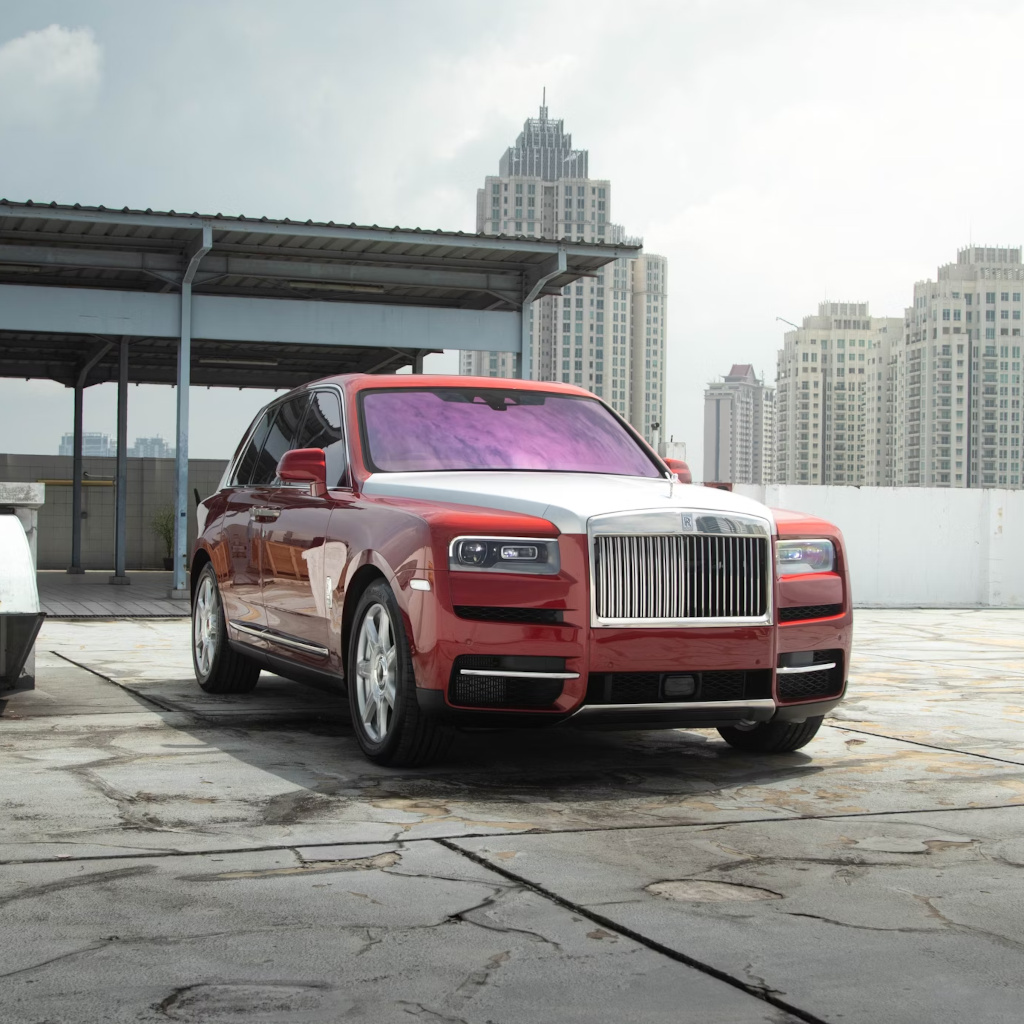

In [4]:
# Image source: https://unsplash.com/photos/a-red-rolls-royce-parked-in-front-of-a-building-sAN11DGnjqk
prompt = 'a photo of a beautiful red car on the top deck of a parking garage with large buildings in the background, hazy weather with sunshine'
ref_image = Image.open('./example_images/rolls_royce.jpg')
print(f'Inversion prompt: "{prompt}"')
display(ref_image)

In [5]:
# Default ReNoise settings, only inversion strength decreased slightly to improve consistency (similar to delayed application in our paper)
model_type = Model_Type.SDXL_Turbo
scheduler_type = Scheduler_Type.EULER
first_step_range_end = 5
number_of_renoising_iterations = 9
inersion_strength = 0.8 # 1.0
avg_gradients_type = Gradient_Averaging_Type.ON_END
first_step_range = (0, 5)
rest_step_range = (8, 10)
lambda_ac = 20.0
lambda_kl = 0.055
update_epsilon_type = Epsilon_Update_Type.OPTIMIZE
config = RunConfig(model_type = model_type,
    num_inference_steps = 4,
    num_inversion_steps = 4, 
    guidance_scale = 0.0,
    max_num_aprox_steps_first_step = first_step_range_end+1,
    num_aprox_steps = number_of_renoising_iterations,
    inversion_max_step = inersion_strength,
    gradient_averaging_type = avg_gradients_type,
    gradient_averaging_first_step_range = first_step_range,
    gradient_averaging_step_range = rest_step_range,
    scheduler_type = scheduler_type,
    num_reg_steps = 4,
    num_ac_rolls = 5,
    lambda_ac = lambda_ac,
    lambda_kl = lambda_kl,
    update_epsilon_type = update_epsilon_type,
    do_reconstruction = True
)
image_size = model_type_to_size(Model_Type.SDXL_Turbo)

pipe_inversion, pipe_inference = get_pipes(model_type, scheduler_type, device=DEVICE)
pipe_inversion.safety_checker = None
pipe_inference.safety_checker = None

Keyword arguments {'safety_checker': None} are not expected by SDXLDDIMPipeline and will be ignored.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Keyword arguments {'safety_checker': None} are not expected by StableDiffusionXLImg2ImgPipeline and will be ignored.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Inverted Image


/export/home/ra63ral/miniconda3/envs/concept_delta/lib/python3.11/site-packages/diffusers/configuration_utils.py:139: FutureWarning: Accessing config attribute `vae` directly via 'StableDiffusionXLPipeline' object attribute is deprecated. Please access 'vae' over 'StableDiffusionXLPipeline's config object instead, e.g. 'scheduler.config.vae'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)
/export/home/ra63ral/miniconda3/envs/concept_delta/lib/python3.11/site-packages/diffusers/configuration_utils.py:139: FutureWarning: Accessing config attribute `unet` directly via 'StableDiffusionXLPipeline' object attribute is deprecated. Please access 'unet' over 'StableDiffusionXLPipeline's config object instead, e.g. 'scheduler.config.unet'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


  0%|          | 0/3 [00:00<?, ?it/s]

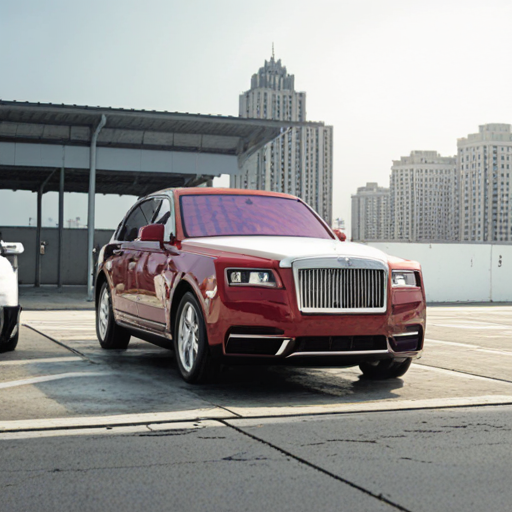

In [6]:
# Inversion code, adapted from https://huggingface.co/spaces/garibida/ReNoise-Inversion/blob/main/main.py

if config.scheduler_type == Scheduler_Type.EULER or config.scheduler_type == Scheduler_Type.LCM or config.scheduler_type == Scheduler_Type.DDPM:
    g_cpu = torch.Generator().manual_seed(7865)
    img_size = model_type_to_size(config.model_type)
    VQAE_SCALE = 8
    latents_size = (1, 4, img_size[0] // VQAE_SCALE, img_size[1] // VQAE_SCALE)
    noise = [randn_tensor(latents_size, dtype=torch.float16, device=torch.device(DEVICE), generator=g_cpu) for i in range(config.num_inversion_steps)]
    pipe_inversion.scheduler.set_noise_list(noise)
    pipe_inference.scheduler.set_noise_list(noise)
    pipe_inversion.scheduler_inference.set_noise_list(noise)
else:
    raise NotImplementedError()

if config.save_gpu_mem:
    pipe_inference.to("cpu")
    pipe_inversion.to(DEVICE)
pipe_inversion.cfg = config
pipe_inference.cfg = config

res = pipe_inversion(
    prompt = config.prompt,
    num_inversion_steps = config.num_inversion_steps,
    num_inference_steps = config.num_inference_steps,
    image = ref_image.convert('RGB').resize(image_size),
    guidance_scale = config.guidance_scale,
    opt_iters = config.opt_iters,
    opt_lr = config.opt_lr,
    callback_on_step_end = inversion_callback,
    strength = config.inversion_max_step,
    denoising_start = 1.0-config.inversion_max_step,
    opt_loss_kl_lambda = config.loss_kl_lambda,
    num_aprox_steps = config.num_aprox_steps
)
latents = res[0][0]
all_latents = res[1]

print('Inverted Image')
if config.save_gpu_mem:
    pipe_inference.to(DEVICE)
    pipe_inversion.to("cpu")
display(pipe_inference(
    **model._get_pipe_kwargs([model.embed_prompt(prompt)]),
    num_inference_steps=config.num_inference_steps,
    negative_prompt=config.prompt,
    callback_on_step_end=inference_callback,
    image=latents,
    strength=config.inversion_max_step,
    denoising_start=1.0 - config.inversion_max_step,
    guidance_scale=1.0
).images[0])

## Attribute Delta-based Editing
After inverting the image, we can simply apply any deltas to any subject like we're used to doing with our method.

In [7]:
delta = EmbeddingDelta(model.dims)
state_dict = torch.load('../../pretrained_deltas/car_age.pt')
delta.load_state_dict(state_dict['delta'])
delta = delta.to(DEVICE)

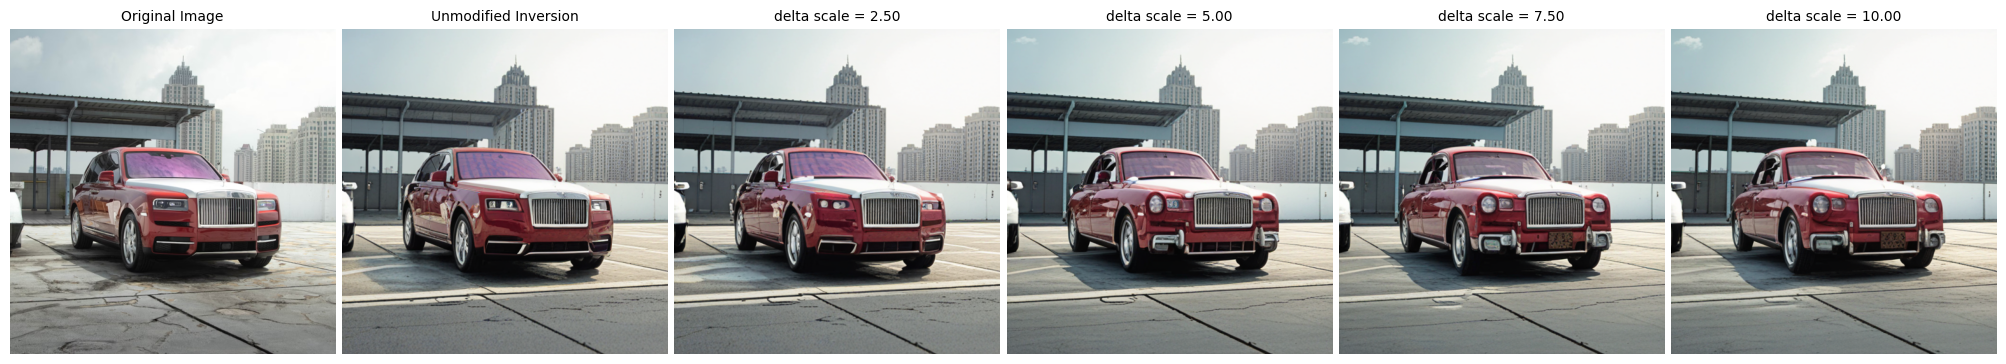

In [8]:
pattern_target = r'\b(car)\b'
delta_scales = np.linspace(0, 10, num=5)
guidance_scale = 1.0

# Sample from the set of provided scales
characterwise_mask = get_mask_regex(prompt, pattern_target)
emb = model.embed_prompt(prompt)
imgs = []
for alpha in delta_scales:
    img = pipe_inference(
        **model._get_pipe_kwargs([delta.apply(model.embed_prompt(prompt), get_mask_regex(prompt, pattern_target), alpha)]),
        num_inference_steps=config.num_inference_steps,
        negative_prompt=config.prompt,
        callback_on_step_end=inference_callback,
        image=latents,
        strength=config.inversion_max_step,
        denoising_start=1.0 - config.inversion_max_step,
        guidance_scale=guidance_scale
    ).images[0]
    imgs.append(img)

    # Display outputs
    clear_output()
    plt.figure(figsize=(max(10, 4 * len(imgs)), 5))
    plt.subplot(1, len(imgs) + 1, 1)
    plt.imshow(ref_image.convert('RGB').resize(image_size))
    plt.title(f'Original Image', fontsize=10)
    plt.axis('off')
    for i, (alpha, img) in enumerate(zip(delta_scales, imgs, strict=False)):
        plt.subplot(1, len(imgs) + 1, i + 2)
        plt.imshow(img)
        plt.title(f'delta scale = {alpha:.2f}' if alpha != 0 else 'Unmodified Inversion', fontsize=10)
        plt.axis('off')
    plt.tight_layout(pad=0.5, h_pad=1.0, w_pad=0.5)
    plt.subplots_adjust(top=0.9)
    plt.show()